In [1]:
import os, gc
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from tqdm import tqdm

PARQUET_PATH = "New_60s_bucket.parquet"
WINDOW       = 30
ROLL_STEP    = 30
EPOCHS       = 60
BATCH_SIZE   = 128
SCALE_FACTOR = 1_000.0
feature_cols = [
    "log_ret_mean", "log_ret_std", "log_ret_sum",
    "abs_volatility", "spread", "imbalance",
    "depth_ratio", "rv_rolling", "mom_rolling"
]
target_col = "realized_volatility"
tf.random.set_seed(42)

df = pd.read_parquet(PARQUET_PATH)
df["date"] = pd.to_datetime(df["date"])
df["day_of_week"] = df["date"].dt.dayofweek + 1
df["week"] = df["date"].dt.isocalendar().week          


TUNE_EPOCHS       = 10    
ALPHA_FINE_TUNE   = 0.30   
UPDATE_ALPHA_ROLL = 0.3  


cluster 0

C0-stock-week: 100%|██████████| 120/120 [08:34<00:00,  4.28s/it]


Cluster 0 metrics appended to weekly_metrics_realtime.csv
C0 R²: 0.7436832464150452


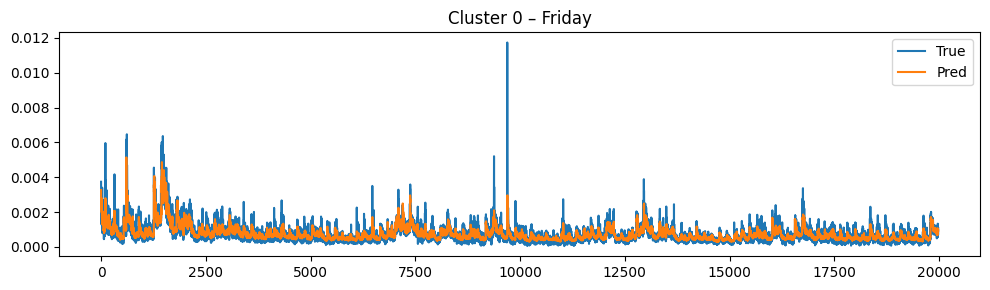

In [2]:
cl_id = 0
sub_c0 = df[df["cluster"] == cl_id].copy()

c0_X_tr, c0_y_tr = [], []
for _, g in tqdm(
        sub_c0[sub_c0.day_of_week <= 4]
        .groupby(["stock_id", "time_id"]),
        desc=f"C{cl_id}-train"):
    g = g.sort_values("bucket_start")
    for i in range(WINDOW, len(g)):
        c0_X_tr.append(g.iloc[i-WINDOW:i][feature_cols].values)
        c0_y_tr.append(g.iloc[i][target_col])

c0_X_tr = np.array(c0_X_tr)
c0_y_tr = np.array(c0_y_tr)
n_feat  = c0_X_tr.shape[2]

c0_scaler = StandardScaler()
c0_scaler.fit(c0_X_tr.reshape(-1, n_feat))
c0_X_tr_s = c0_scaler.transform(c0_X_tr.reshape(-1, n_feat)
               ).reshape(c0_X_tr.shape)
c0_y_tr_t = np.log1p(c0_y_tr) * SCALE_FACTOR

c0_model = Sequential([
    LSTM(64, input_shape=(WINDOW, n_feat)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])
c0_model.compile(optimizer="adam", loss="mse")
c0_model.fit(c0_X_tr_s, c0_y_tr_t,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_split=0.1,
             shuffle=False,
             verbose=0)

base_weights = c0_model.get_weights()  


cluster_mean_val = sub_c0[target_col].mean()


c0_true_all, c0_pred_all = [], []


rows_to_dump = []

for (sid, wk), sidwk_df in tqdm(sub_c0.groupby(["stock_id", "week"]),
                                desc=f"C{cl_id}-stock-week"):

    
    c0_model.set_weights(base_weights)
    mon_thu = sidwk_df[sidwk_df.day_of_week <= 4]

    X_ft, y_ft = [], []
    for _, g in mon_thu.groupby(["stock_id", "time_id"]):
        g = g.sort_values("bucket_start")
        for i in range(WINDOW, len(g)):
            X_ft.append(g.iloc[i-WINDOW:i][feature_cols].values)
            y_ft.append(g.iloc[i][target_col])

    if X_ft:
        X_ft = np.array(X_ft)
        y_ft = np.array(y_ft)
        X_ft_s = c0_scaler.transform(
            X_ft.reshape(-1, n_feat)).reshape(X_ft.shape)
        y_ft_t = np.log1p(y_ft) * SCALE_FACTOR

        c0_model.fit(X_ft_s, y_ft_t,
                     epochs=TUNE_EPOCHS,
                     batch_size=BATCH_SIZE,
                     shuffle=False,
                     verbose=0)

        tuned = c0_model.get_weights()
        blended = [(1-ALPHA_FINE_TUNE)*bw + ALPHA_FINE_TUNE*tw
                   for bw, tw in zip(base_weights, tuned)]
        c0_model.set_weights(blended)

    
    local_true, local_pred = [], []
    fri_df = sidwk_df[sidwk_df.day_of_week == 5]

    for _, g in fri_df.groupby(["stock_id", "time_id"]):
        g = g.sort_values("bucket_start")
        feats = c0_scaler.transform(g[feature_cols].values)

        for i in range(WINDOW, len(g)):
            X_i = feats[i-WINDOW:i].reshape(1, WINDOW, n_feat)
            y_hat = c0_model.predict(X_i, verbose=0)[0, 0]
            y_hat_inv = np.expm1(y_hat / SCALE_FACTOR)

            
            local_pred.append(y_hat_inv)
            local_true.append(g.iloc[i][target_col])
            c0_pred_all.append(y_hat_inv)
            c0_true_all.append(g.iloc[i][target_col])

            
            if (i - WINDOW + 1) % ROLL_STEP == 0:
                X_new = feats[i-WINDOW+1:i+1].reshape(1, WINDOW, n_feat)
                y_new = np.log1p([g.iloc[i][target_col]]) * SCALE_FACTOR

                original_w = c0_model.get_weights()
                c0_model.train_on_batch(X_new, y_new)
                updated_w  = c0_model.get_weights()
                blended_w  = [
                    (1-UPDATE_ALPHA_ROLL)*ow + UPDATE_ALPHA_ROLL*uw
                    for ow, uw in zip(original_w, updated_w)
                ]
                c0_model.set_weights(blended_w)

    
    if local_true:  
        y_t = np.asarray(local_true, dtype=float)
        y_p = np.asarray(local_pred, dtype=float)

        
        def median_absolute_error(t, p):
            return np.median(np.abs(t - p))
        def mape(t, p):
            t = np.clip(t, 1e-8, None)
            return np.mean(np.abs((t - p) / t)) * 100
        def smape(t, p):
            denom = np.clip(np.abs(t) + np.abs(p), 1e-8, None)
            return np.mean(2*np.abs(p - t) / denom) * 100
        def qlike(t, p):
            t = np.clip(t, 1e-8, None)
            p = np.clip(p, 1e-8, None)
            return np.mean(np.log(p) + t / p)
        def cluster_r2(t, p, gmean):
            ss_res = np.sum((t - p)**2)
            ss_tot = np.sum((t - gmean)**2)
            return np.nan if ss_tot == 0 else 1 - ss_res / ss_tot

        rows_to_dump.append({
            "cluster":  cl_id,
            "stock":    sid,
            "week":     wk,
            "model":    f"cluster{cl_id}_model",
            "R2":       cluster_r2(y_t, y_p, cluster_mean_val),
            "RMSE":     np.sqrt(mean_squared_error(y_t, y_p)),
            "MAE":      mean_absolute_error(y_t, y_p),
            "MedAE":    median_absolute_error(y_t, y_p),
            "MAPE(%)":  mape(y_t, y_p),
            "SMAPE(%)": smape(y_t, y_p),
            "QLIKE":    qlike(y_t, y_p)
        })


METRICS_CSV = "weekly_metrics_realtime.csv"
first_write = (cl_id == 0) and (not os.path.exists(METRICS_CSV))

if rows_to_dump:
    pd.DataFrame(rows_to_dump).to_csv(
        METRICS_CSV,
        mode="w" if first_write else "a",
        header=first_write,
        index=False
    )
    print(f"Cluster {cl_id} metrics appended to {METRICS_CSV}")
else:
    print(f"Cluster {cl_id} has no data")


print(f"C{cl_id} R²:",
      r2_score(c0_true_all, c0_pred_all))

plt.figure(figsize=(10, 3))
plt.plot(c0_true_all, label="True")
plt.plot(c0_pred_all, label="Pred")
plt.title(f"Cluster {cl_id} – Friday")
plt.legend()
plt.tight_layout()
plt.show()


cluster 1

C1-stock-week: 100%|██████████| 166/166 [12:13<00:00,  4.42s/it]


Cluster 1 metrics appended to weekly_metrics_realtime.csv
C1 R²: 0.6979088320613037


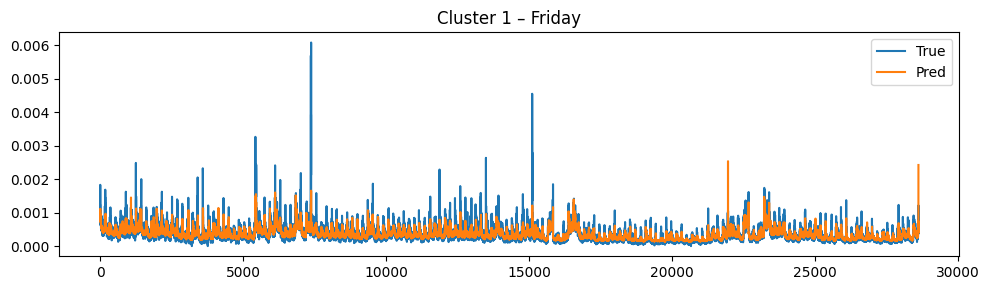

In [3]:
cl_id = 1
sub_c1 = df[df["cluster"] == cl_id].copy()

c1_X_tr, c1_y_tr = [], []
for _, g in tqdm(
        sub_c1[sub_c1.day_of_week <= 4]
        .groupby(["stock_id", "time_id"]),
        desc=f"C{cl_id}-train"):
    g = g.sort_values("bucket_start")
    for i in range(WINDOW, len(g)):
        c1_X_tr.append(g.iloc[i-WINDOW:i][feature_cols].values)
        c1_y_tr.append(g.iloc[i][target_col])

c1_X_tr = np.array(c1_X_tr)
c1_y_tr = np.array(c1_y_tr)
n_feat  = c1_X_tr.shape[2]

c1_scaler = StandardScaler()
c1_scaler.fit(c1_X_tr.reshape(-1, n_feat))
c1_X_tr_s = c1_scaler.transform(c1_X_tr.reshape(-1, n_feat)
               ).reshape(c1_X_tr.shape)
c1_y_tr_t = np.log1p(c1_y_tr) * SCALE_FACTOR

c1_model = Sequential([
    LSTM(64, input_shape=(WINDOW, n_feat)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])
c1_model.compile(optimizer="adam", loss="mse")
c1_model.fit(c1_X_tr_s, c1_y_tr_t,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_split=0.1,
             shuffle=False,
             verbose=0)

base_weights = c1_model.get_weights()  

cluster_mean_val = sub_c1[target_col].mean()

c1_true_all, c1_pred_all = [], []

rows_to_dump = []

for (sid, wk), sidwk_df in tqdm(sub_c1.groupby(["stock_id", "week"]),
                                desc=f"C{cl_id}-stock-week"):

    c1_model.set_weights(base_weights)
    mon_thu = sidwk_df[sidwk_df.day_of_week <= 4]

    X_ft, y_ft = [], []
    for _, g in mon_thu.groupby(["stock_id", "time_id"]):
        g = g.sort_values("bucket_start")
        for i in range(WINDOW, len(g)):
            X_ft.append(g.iloc[i-WINDOW:i][feature_cols].values)
            y_ft.append(g.iloc[i][target_col])

    if X_ft:
        X_ft = np.array(X_ft)
        y_ft = np.array(y_ft)
        X_ft_s = c1_scaler.transform(
            X_ft.reshape(-1, n_feat)).reshape(X_ft.shape)
        y_ft_t = np.log1p(y_ft) * SCALE_FACTOR

        c1_model.fit(X_ft_s, y_ft_t,
                     epochs=TUNE_EPOCHS,
                     batch_size=BATCH_SIZE,
                     shuffle=False,
                     verbose=0)

        tuned = c1_model.get_weights()
        blended = [(1-ALPHA_FINE_TUNE)*bw + ALPHA_FINE_TUNE*tw
                   for bw, tw in zip(base_weights, tuned)]
        c1_model.set_weights(blended)

    local_true, local_pred = [], []
    fri_df = sidwk_df[sidwk_df.day_of_week == 5]

    for _, g in fri_df.groupby(["stock_id", "time_id"]):
        g = g.sort_values("bucket_start")
        feats = c1_scaler.transform(g[feature_cols].values)

        for i in range(WINDOW, len(g)):
            X_i = feats[i-WINDOW:i].reshape(1, WINDOW, n_feat)
            y_hat = c1_model.predict(X_i, verbose=0)[0, 0]
            y_hat_inv = np.expm1(y_hat / SCALE_FACTOR)

            local_pred.append(y_hat_inv)
            local_true.append(g.iloc[i][target_col])
            c1_pred_all.append(y_hat_inv)
            c1_true_all.append(g.iloc[i][target_col])

            if (i - WINDOW + 1) % ROLL_STEP == 0:
                X_new = feats[i-WINDOW+1:i+1].reshape(1, WINDOW, n_feat)
                y_new = np.log1p([g.iloc[i][target_col]]) * SCALE_FACTOR

                original_w = c1_model.get_weights()
                c1_model.train_on_batch(X_new, y_new)
                updated_w  = c1_model.get_weights()
                blended_w  = [
                    (1-UPDATE_ALPHA_ROLL)*ow + UPDATE_ALPHA_ROLL*uw
                    for ow, uw in zip(original_w, updated_w)
                ]
                c1_model.set_weights(blended_w)

    if local_true:  
        y_t = np.asarray(local_true, dtype=float)
        y_p = np.asarray(local_pred, dtype=float)

        def median_absolute_error(t, p):
            return np.median(np.abs(t - p))
        def mape(t, p):
            t = np.clip(t, 1e-8, None)
            return np.mean(np.abs((t - p) / t)) * 100
        def smape(t, p):
            denom = np.clip(np.abs(t) + np.abs(p), 1e-8, None)
            return np.mean(2*np.abs(p - t) / denom) * 100
        def qlike(t, p):
            t = np.clip(t, 1e-8, None)
            p = np.clip(p, 1e-8, None)
            return np.mean(np.log(p) + t / p)
        def cluster_r2(t, p, gmean):
            ss_res = np.sum((t - p)**2)
            ss_tot = np.sum((t - gmean)**2)
            return np.nan if ss_tot == 0 else 1 - ss_res / ss_tot

        rows_to_dump.append({
            "cluster":  cl_id,
            "stock":    sid,
            "week":     wk,
            "model":    f"cluster{cl_id}_model",
            "R2":       cluster_r2(y_t, y_p, cluster_mean_val),
            "RMSE":     np.sqrt(mean_squared_error(y_t, y_p)),
            "MAE":      mean_absolute_error(y_t, y_p),
            "MedAE":    median_absolute_error(y_t, y_p),
            "MAPE(%)":  mape(y_t, y_p),
            "SMAPE(%)": smape(y_t, y_p),
            "QLIKE":    qlike(y_t, y_p)
        })


METRICS_CSV = "weekly_metrics_realtime.csv"
first_write = (cl_id == 0) and (not os.path.exists(METRICS_CSV))

if rows_to_dump:
    pd.DataFrame(rows_to_dump).to_csv(
        METRICS_CSV,
        mode="w" if first_write else "a",
        header=first_write,
        index=False
    )
    print(f"Cluster {cl_id} metrics appended to {METRICS_CSV}")
else:
    print(f"Cluster {cl_id} has no data")

print(f"C{cl_id} R²:",
      r2_score(c1_true_all, c1_pred_all))

plt.figure(figsize=(10, 3))
plt.plot(c1_true_all, label="True")
plt.plot(c1_pred_all, label="Pred")
plt.title(f"Cluster {cl_id} – Friday")
plt.legend()
plt.tight_layout()
plt.show()


cluster 2

C2-stock-week: 100%|██████████| 114/114 [09:34<00:00,  5.04s/it]


Cluster 2 metrics appended to weekly_metrics_realtime.csv
C2 R²: 0.5103292156919578


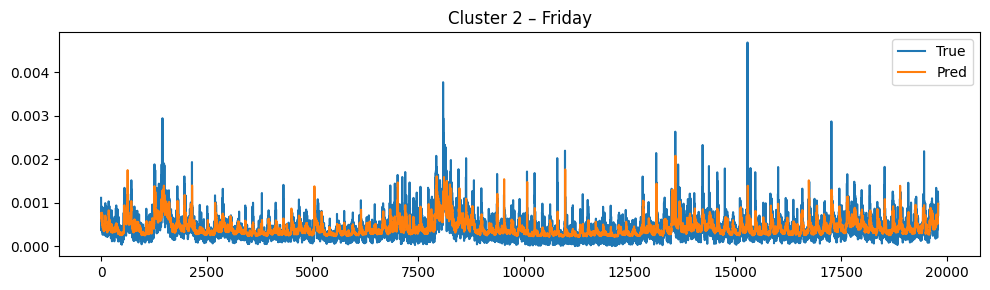

In [4]:
cl_id = 2
sub_c2 = df[df["cluster"] == cl_id].copy()

c2_X_tr, c2_y_tr = [], []
for _, g in tqdm(
        sub_c2[sub_c2.day_of_week <= 4]
        .groupby(["stock_id", "time_id"]),
        desc=f"C{cl_id}-train"):
    g = g.sort_values("bucket_start")
    for i in range(WINDOW, len(g)):
        c2_X_tr.append(g.iloc[i-WINDOW:i][feature_cols].values)
        c2_y_tr.append(g.iloc[i][target_col])

c2_X_tr = np.array(c2_X_tr)
c2_y_tr = np.array(c2_y_tr)
n_feat  = c2_X_tr.shape[2]

c2_scaler = StandardScaler()
c2_scaler.fit(c2_X_tr.reshape(-1, n_feat))
c2_X_tr_s = c2_scaler.transform(c2_X_tr.reshape(-1, n_feat)
               ).reshape(c2_X_tr.shape)
c2_y_tr_t = np.log1p(c2_y_tr) * SCALE_FACTOR

c2_model = Sequential([
    LSTM(64, input_shape=(WINDOW, n_feat)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])
c2_model.compile(optimizer="adam", loss="mse")
c2_model.fit(c2_X_tr_s, c2_y_tr_t,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_split=0.1,
             shuffle=False,
             verbose=0)

base_weights = c2_model.get_weights()  

cluster_mean_val = sub_c2[target_col].mean()

c2_true_all, c2_pred_all = [], []

rows_to_dump = []

for (sid, wk), sidwk_df in tqdm(sub_c2.groupby(["stock_id", "week"]),
                                desc=f"C{cl_id}-stock-week"):

    c2_model.set_weights(base_weights)
    mon_thu = sidwk_df[sidwk_df.day_of_week <= 4]

    X_ft, y_ft = [], []
    for _, g in mon_thu.groupby(["stock_id", "time_id"]):
        g = g.sort_values("bucket_start")
        for i in range(WINDOW, len(g)):
            X_ft.append(g.iloc[i-WINDOW:i][feature_cols].values)
            y_ft.append(g.iloc[i][target_col])

    if X_ft:
        X_ft = np.array(X_ft)
        y_ft = np.array(y_ft)
        X_ft_s = c2_scaler.transform(
            X_ft.reshape(-1, n_feat)).reshape(X_ft.shape)
        y_ft_t = np.log1p(y_ft) * SCALE_FACTOR

        c2_model.fit(X_ft_s, y_ft_t,
                     epochs=TUNE_EPOCHS,
                     batch_size=BATCH_SIZE,
                     shuffle=False,
                     verbose=0)

        tuned = c2_model.get_weights()
        blended = [(1-ALPHA_FINE_TUNE)*bw + ALPHA_FINE_TUNE*tw
                   for bw, tw in zip(base_weights, tuned)]
        c2_model.set_weights(blended)

    local_true, local_pred = [], []
    fri_df = sidwk_df[sidwk_df.day_of_week == 5]

    for _, g in fri_df.groupby(["stock_id", "time_id"]):
        g = g.sort_values("bucket_start")
        feats = c2_scaler.transform(g[feature_cols].values)

        for i in range(WINDOW, len(g)):
            X_i = feats[i-WINDOW:i].reshape(1, WINDOW, n_feat)
            y_hat = c2_model.predict(X_i, verbose=0)[0, 0]
            y_hat_inv = np.expm1(y_hat / SCALE_FACTOR)

            local_pred.append(y_hat_inv)
            local_true.append(g.iloc[i][target_col])
            c2_pred_all.append(y_hat_inv)
            c2_true_all.append(g.iloc[i][target_col])

            if (i - WINDOW + 1) % ROLL_STEP == 0:
                X_new = feats[i-WINDOW+1:i+1].reshape(1, WINDOW, n_feat)
                y_new = np.log1p([g.iloc[i][target_col]]) * SCALE_FACTOR

                original_w = c2_model.get_weights()
                c2_model.train_on_batch(X_new, y_new)
                updated_w  = c2_model.get_weights()
                blended_w  = [
                    (1-UPDATE_ALPHA_ROLL)*ow + UPDATE_ALPHA_ROLL*uw
                    for ow, uw in zip(original_w, updated_w)
                ]
                c2_model.set_weights(blended_w)

    if local_true:  
        y_t = np.asarray(local_true, dtype=float)
        y_p = np.asarray(local_pred, dtype=float)

        def median_absolute_error(t, p):
            return np.median(np.abs(t - p))
        def mape(t, p):
            t = np.clip(t, 1e-8, None)
            return np.mean(np.abs((t - p) / t)) * 100
        def smape(t, p):
            denom = np.clip(np.abs(t) + np.abs(p), 1e-8, None)
            return np.mean(2*np.abs(p - t) / denom) * 100
        def qlike(t, p):
            t = np.clip(t, 1e-8, None)
            p = np.clip(p, 1e-8, None)
            return np.mean(np.log(p) + t / p)
        def cluster_r2(t, p, gmean):
            ss_res = np.sum((t - p)**2)
            ss_tot = np.sum((t - gmean)**2)
            return np.nan if ss_tot == 0 else 1 - ss_res / ss_tot

        rows_to_dump.append({
            "cluster":  cl_id,
            "stock":    sid,
            "week":     wk,
            "model":    f"cluster{cl_id}_model",
            "R2":       cluster_r2(y_t, y_p, cluster_mean_val),
            "RMSE":     np.sqrt(mean_squared_error(y_t, y_p)),
            "MAE":      mean_absolute_error(y_t, y_p),
            "MedAE":    median_absolute_error(y_t, y_p),
            "MAPE(%)":  mape(y_t, y_p),
            "SMAPE(%)": smape(y_t, y_p),
            "QLIKE":    qlike(y_t, y_p)
        })


METRICS_CSV = "weekly_metrics_realtime.csv"
first_write = (cl_id == 0) and (not os.path.exists(METRICS_CSV))

if rows_to_dump:
    pd.DataFrame(rows_to_dump).to_csv(
        METRICS_CSV,
        mode="w" if first_write else "a",
        header=first_write,
        index=False
    )
    print(f"Cluster {cl_id} metrics appended to {METRICS_CSV}")
else:
    print(f"Cluster {cl_id} has no data")

print(f"C{cl_id} R²:",
      r2_score(c2_true_all, c2_pred_all))

plt.figure(figsize=(10, 3))
plt.plot(c2_true_all, label="True")
plt.plot(c2_pred_all, label="Pred")
plt.title(f"Cluster {cl_id} – Friday")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
c0_true = np.array(c0_true_all)
c0_pred = np.array(c0_pred_all)
c0_mae  = np.abs(c0_true - c0_pred)
c0_mse  = (c0_true - c0_pred)**2
c0_rmse = np.sqrt(c0_mse)
c1_true = np.array(c1_true_all)
c1_pred = np.array(c1_pred_all)
c1_mae  = np.abs(c1_true - c1_pred)
c1_mse  = (c1_true - c1_pred)**2
c1_rmse = np.sqrt(c1_mse)
c2_true = np.array(c2_true_all)
c2_pred = np.array(c2_pred_all)
c2_mae  = np.abs(c2_true - c2_pred)
c2_mse  = (c2_true - c2_pred)**2
c2_rmse = np.sqrt(c2_mse)

Result Visualisation

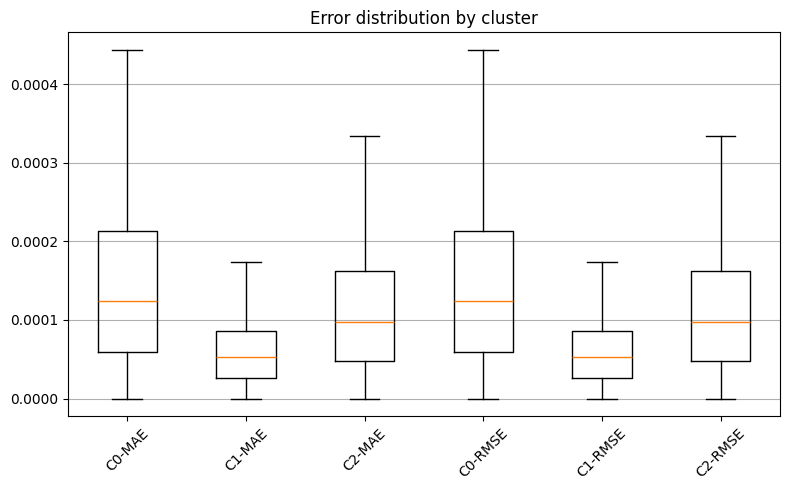

In [11]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [c0_mae, c1_mae, c2_mae,
     c0_rmse,c1_rmse,c2_rmse],
    labels=["C0-MAE","C1-MAE","C2-MAE",
            "C0-RMSE","C1-RMSE","C2-RMSE"],
    showfliers=False
)
plt.xticks(rotation=45)
plt.title("Error distribution by cluster")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


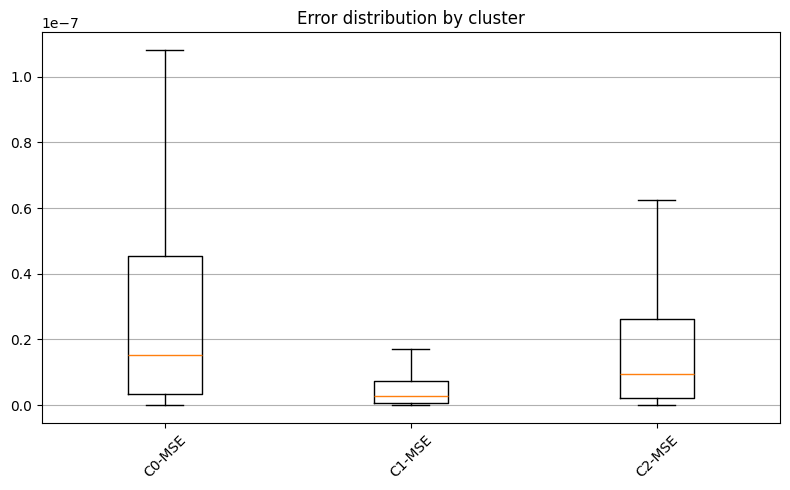

In [12]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [c0_mse, c1_mse, c2_mse],
    labels=["C0-MSE","C1-MSE","C2-MSE"],
    showfliers=False
)
plt.xticks(rotation=45)
plt.title("Error distribution by cluster")
plt.grid(axis="y")
plt.tight_layout()
plt.show()